# Modelo Matematico

In [1]:
# Librerias
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint


In [2]:
#Definicion de las ecuaciones diferenciales

#Don't track S because all variables must add up to 1 
#Include blank first entry in vector for beta, gamma, p so that indices align in equations and code. 
#In the future could include recovery or infection from the exposed class (asymptomatics)


# Sin tomar como S de variable

def seir(y,t,b,a,g,p,u,N): 
    dy=[0,0,0,0,0,0]
    S=N-sum(y);
    dy[0]=np.dot(b[1:3],y[1:3])*S-a*y[0] # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1] #I1
    dy[2]= p[1]*y[1] -(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3]) #R
    dy[5]=u*y[3] #D

    return dy

# Tomando como S de variable

def diff_eqs(y,t,b,a,g,p,u,N): 
    
    dy=[0,0,0,0,0,0,0]
    
    #S=N-sum(y);
    dy[0]= -np.dot(b[1:3],y[2:4])*y[0]         #S
    dy[1]= np.dot(b[1:3],y[2:4])*y[0]-a*y[1]   #E
    dy[2]= a*y[1]-(g[1]+p[1])*y[2]             #I1
    dy[3]= p[1]*y[2] -(g[2]+p[2])*y[3]         #I2
    dy[4]= p[2]*y[3] -(g[3]+u)*y[4]            #I3
    dy[5]= np.dot(g[1:3],y[2:4])               #R
    dy[6]= u*y[4]                              #D

    return dy

In [3]:
# Definicion de parametros en base a observaciones medicas
# Fuente: https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus

#Incubation period, days
IncubPeriod=5  

#Duration of mild infections, days
DurMildInf=10 

#Fraction of infections that are mild
FracMild=0.8  

#Fraction of infections that are severe
FracSevere=0.15 

#Fraction of infections that are critical
FracCritical=0.05 

#Case fatality rate (fraction of infections resulting in death)
CFR=0.02 

#Time from ICU admission to death, days
TimeICUDeath=7 

#Duration of hospitalization, days
DurHosp=11 



In [4]:
# Definicion de paramtetros

# Numero de Pacientes
N=1000
# Parametro Beta asociado al ratio en que los infectados contagian a los S (suceptibles)
b=np.zeros(4) 
b=2e-4*np.ones(4) # all stages transmit equally
#b=2.5e-4*np.array([0,1,0,0]) # hospitalized cases don't transmit

# Parametro Gamma asociado al ratio en el que las personas infectadas se recuperan
g=np.zeros(4) 

# Parametro en que la personas infectadas pasan de 1 esta a otro (1,2,3)
p=np.zeros(3) 

# Rate from the exposed to infected
a=1/IncubPeriod 

# Ratio de muerte
u=(1/TimeICUDeath)*(CFR/FracCritical)  


p[1]=(1/DurMildInf)-g[1]
p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))


g[1]=(1/DurMildInf)*FracMild
g[2]=(1/DurHosp)-p[2]
g[3]=(1/TimeICUDeath)-u


# Calculo del ratio de Reproduccion RO
R0=N*((b[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(b[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(b[3]/(u+g[3]))))



In [5]:
print("Beta: ", b)
print("Rate from the exposed to infected: ", a)
print("Gamma: ", g)
print("Ratio de Infeccion entre Infectados: ", p)
print("Ratio de muerte: ", u)
print("Ratio de Reproduccion RO = {0:4.1f}".format(R0))

Beta:  [0.0002 0.0002 0.0002 0.0002]
Rate from the exposed to infected:  0.2
Gamma:  [0.         0.08       0.06818182 0.08571429]
Ratio de Infeccion entre Infectados:  [0.         0.1        0.02272727]
Ratio de muerte:  0.057142857142857134
Ratio de Reproduccion RO =  2.5


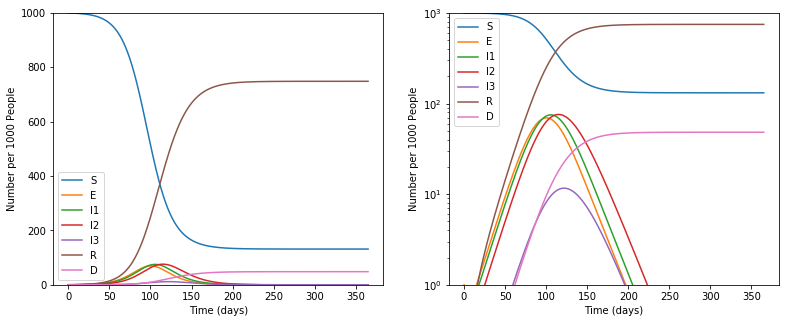

In [6]:
# Analisis de de solucion de ODE

# Puntos de evaluacion
tmax=365
tvec=np.arange(0,tmax,0.1)


# Opcion 1:
# Condiciones Iniciales
#ic=np.zeros(6)
#ic[0]=1
#soln=odeint(seir,ic,tvec,args=(b,a,g,p,u,N))
#soln=np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln))

# Opcion 2:
# Condiciones Iniciales
ic=np.zeros(7)
ic[0]=1000
ic[1]=1

soln=odeint(diff_eqs,ic,tvec,args=(b,a,g,p,u,N))

plt.figure(figsize=(13,5))

#En escala decimal
plt.subplot(1,2,1)
plt.plot(tvec,soln)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([0,1000])

#En escala semilogaritmica
plt.subplot(1,2,2)
plt.plot(tvec,soln)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([1,1000])
#plt.tight_layout()

plt.show()


# Analisis de Insights 

# Crecimiento de la epidemia

In [7]:

# get observed growth rate r (and doubling time) for a particular variable between selected time points
#(all infected classes eventually grow at same rate during early infection)

#Don't have a simple analytic formula for r for this model due to the complexity of the stages

def growth_rate(tvec,soln,t1,t2,i):
    i1=np.where(tvec==t1)[0][0]
    i2=np.where(tvec==t2)[0][0]
    r=(np.log(soln[i2,1])-np.log(soln[i1,1]))/(t2-t1)
    DoublingTime=np.log(2)/r

    return r, DoublingTime

In [8]:
(r,DoublingTime)=growth_rate(tvec,soln,10,20,1)
print("The epidemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(r,DoublingTime))

The epidemic growth rate is = 0.06 per day and the doubling time 10.9 days 


# Usando mascarillas que reduce el transmision rate

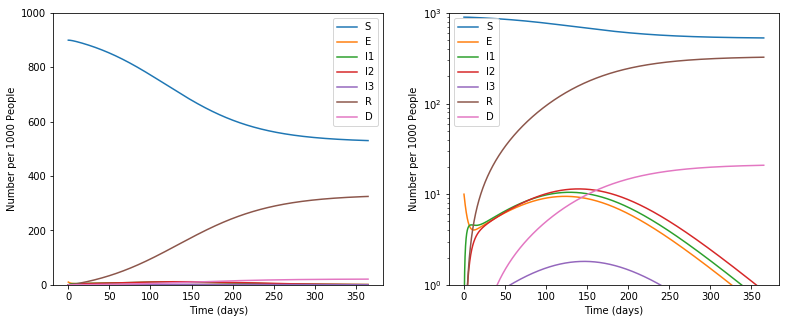

R0 under intervention =  1.5
The epidemic growth rate is = 0.01 per day and the doubling time 56.4 days 


In [9]:
bSlow=0.6*b
R0Slow=N*((bSlow[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(bSlow[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(bSlow[3]/(u+g[3]))))

ic=np.zeros(7)
ic[0]=900
ic[1]=10

solnSlow=odeint(diff_eqs,ic,tvec,args=(bSlow,a,g,p,u,N))

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,solnSlow)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([0,1000])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,solnSlow)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([1,1000])

(rSlow,DoublingTimeSlow)=growth_rate(tvec,solnSlow,30,40,1)

plt.show()
print("R0 under intervention = {0:4.1f}".format(R0Slow))
print("The epidemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(rSlow,DoublingTimeSlow))

# Comparacion de la epidemis con o sin intervenciones

Text(0.5, 1.0, 'All infectious cases')

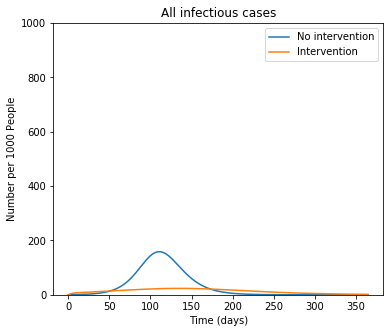

In [10]:

### All infectious cases (not exposed)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,np.sum(soln[:,2:5],axis=1,keepdims=True))
plt.plot(tvec,np.sum(solnSlow[:,2:5],axis=1,keepdims=True))
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("No intervention","Intervention"))
plt.ylim([0,1000])
plt.title('All infectious cases')

# Simulacion SEIR Extendido - SIN RESTRICCION

909 91 0 0 0 0 0
909 0 91 0 0 0 0
844 65 0 84 0 7 0
799 45 65 0 80 11 0
720 79 46 56 0 33 66
664 56 79 41 52 42 66
590 74 58 70 40 51 117
534 56 74 51 67 65 153
477 57 56 67 48 80 215
428 49 57 53 66 88 259
380 48 50 53 47 105 317
342 38 49 44 51 117 359
310 32 39 41 38 133 407
292 18 33 35 41 142 439
273 19 18 31 31 153 475
259 14 19 16 27 162 503
246 13 14 18 15 167 527
239 7 13 12 17 172 540
231 8 7 11 11 175 557
224 7 8 5 10 179 567
216 8 7 8 4 182 575
213 3 8 7 8 183 578
211 2 4 6 6 186 585
205 6 2 3 4 190 590
203 2 6 2 3 190 594
201 2 2 6 2 190 597
199 2 2 2 6 190 599
198 1 2 2 2 190 605
197 1 1 2 1 191 607
197 0 1 1 2 191 608
197 0 0 1 1 191 610
197 0 0 0 1 191 611
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612
197 0 0 0 0 191 612

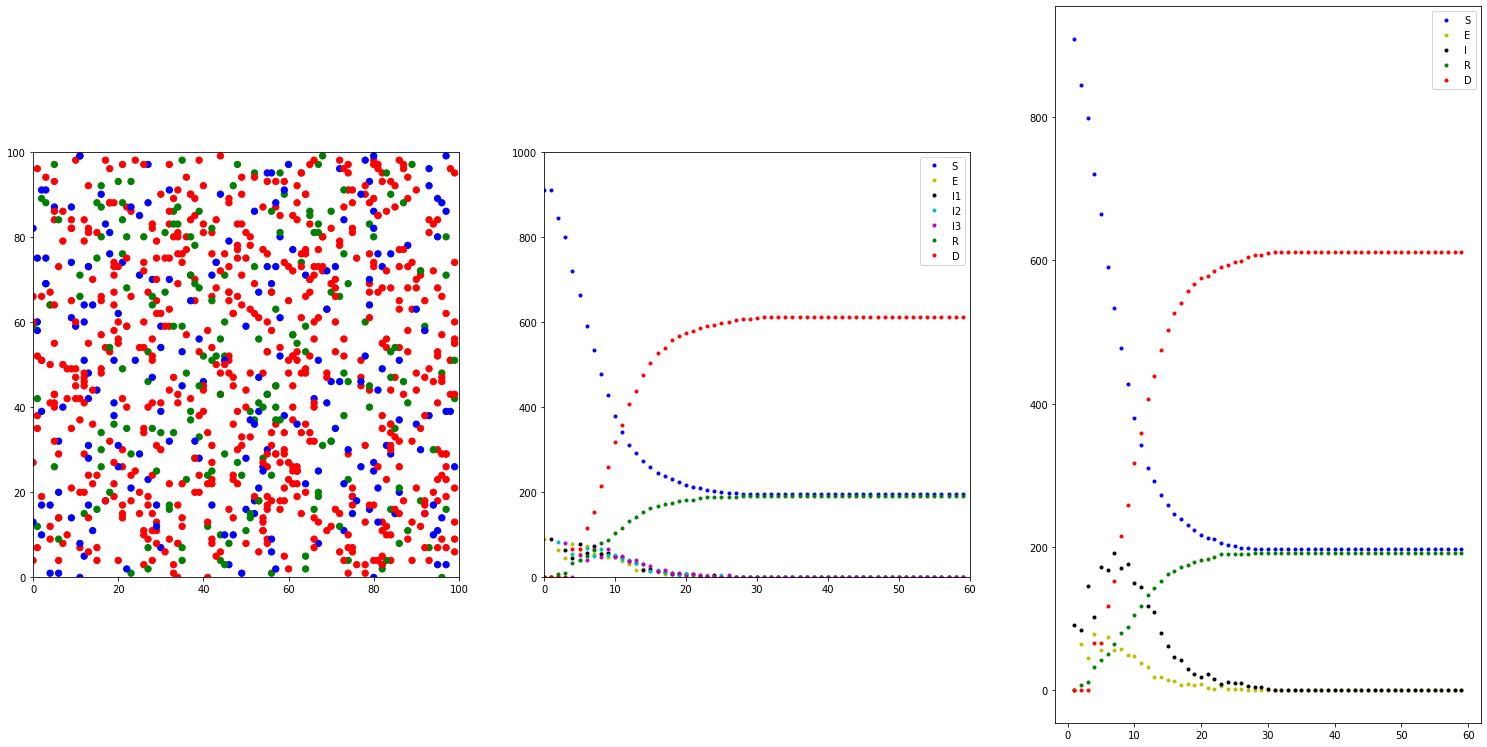

In [14]:
# Modelo SIR extendido

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from random import random as rand
import numpy as np
import scipy.integrate
from math import fabs

fig, (view, demog, sumary) = plt.subplots(1,3, figsize=(15,25))
fig.canvas.manager.window.attributes('-topmost', 0)
label_added = False

# y=[S, E, I1, I2, I3, R, D]

# y[0]=S
# y[1]=E
# y[2]=I1
# y[3]=I2
# y[4]=I3
# y[5]=R
# y[6]=D

Estados=[]

def diff_eqs(y,t,b,a,g,p,u,N): 
    
    dy=[0,0,0,0,0,0,0]
    
    #S=N-sum(y);
    dy[0]= -np.dot(b[1:3],y[2:4])*y[0]         #S
    dy[1]= np.dot(b[1:3],y[2:4])*y[0]-a*y[1]   #E
    dy[2]= a*y[1]-(g[1]+p[1])*y[2]             #I1
    dy[3]= p[1]*y[2] -(g[2]+p[2])*y[3]         #I2
    dy[4]= p[2]*y[3] -(g[3]+u)*y[4]            #I3
    dy[5]= np.dot(g[1:3],y[2:4])               #R
    dy[6]= u*y[4]                              #D

    return dy

def showPlot(end):   
    
    view.clear()
    view.scatter([a.x for a in AGENTS], [a.y for a in AGENTS],
                 s=40, cmap = matplotlib.colors.ListedColormap(["blue", "yellow", "black", "cyan", "magenta", "green", "red"]), c=[a.status for a in AGENTS],
                 vmin=0, vmax=6)
    view.set_aspect(1)
    view.axis([0, SIZE, 0, SIZE])
    
      
    S = len([a for a in AGENTS if a.status == 0])
    E = len([a for a in AGENTS if a.status == 1])
    I1 = len([a for a in AGENTS if a.status == 2])
    I2 = len([a for a in AGENTS if a.status == 3])
    I3 = len([a for a in AGENTS if a.status == 4])
    R = len([a for a in AGENTS if a.status == 5])
    D = len([a for a in AGENTS if a.status == 6])
    
    Estados.append([S, E, I1, I2, I3, R, D])
    print(S, E, I1, I2, I3, R, D)
    
    global label_added
    if label_added:
        demog.plot(TIME, S, 'b.')
        demog.plot(TIME, E, 'y.')
        demog.plot(TIME, I1, 'k.')
        demog.plot(TIME, I2, 'c.')
        demog.plot(TIME, I3, 'm.')
        demog.plot(TIME, R, 'g.')
        demog.plot(TIME, D, 'r.')
        demog.legend(("S","E","I1","I2","I3","R","D"))
        
        I = I1+I2+I3
        
        sumary.plot(TIME, S, 'b.')
        sumary.plot(TIME, E, 'y.')
        sumary.plot(TIME, I, 'k.')
        sumary.plot(TIME, R, 'g.')
        sumary.plot(TIME, D, 'r.')
        sumary.legend(("S","E","I","R","D"))

    else:
        demog.plot(TIME, S, 'b.', label="S")
        demog.plot(TIME, E, 'y.', label="E")
        demog.plot(TIME, I1, 'k.', label="I1")
        demog.plot(TIME, I2, 'c.', label="I2")
        demog.plot(TIME, I3, 'm.', label="I3")
        demog.plot(TIME, R, 'g.', label="R")
        demog.plot(TIME, D, 'r.', label="D")
        label_added = True
    demog.axis([0, MAX_TIME, 0, NAGENTS])
    demog.set_aspect(1.0*MAX_TIME/NAGENTS)

    if end:
        trange = np.arange(0, MAX_TIME, 0.01)
        ode_result = odeint(diff_eqs, IN, trange, args=(b,a,g,p,u,NAGENTS))
        demog.plot(trange, ode_result[:, 0], 'b-')
        demog.plot(trange, ode_result[:, 1], 'y-')
        demog.plot(trange, ode_result[:, 2], 'k-')
        demog.plot(trange, ode_result[:, 3], 'c-')
        demog.plot(trange, ode_result[:, 4], 'm-')
        demog.plot(trange, ode_result[:, 5], 'g-')
        demog.plot(trange, ode_result[:, 6], 'r-')
        demog.plot(trange, NAGENTS - (ode_result[:, 0] + ode_result[:, 1] + ode_result[:, 2] + ode_result[:, 3] + ode_result[:, 4] + ode_result[:, 5] + ode_result[:, 6]), 'g-')
        #demog.xlabel("Time (days)")
        #demog.ylabel("Number per 1000 People")
        #demog.legend(("S","E","I1","I2","I3","R","D"))
        
    plt.draw()
    if end:
        plt.pause(0)
    else:
        plt.pause(0.01)

class Patient:
    def __init__(self, x, y, input_status):
        self.status = input_status  # S=0, E=1, I1=2, I2=3, I3=4, R=5, D=6
        self.x = x
        self.y = y
        self.next_status = input_status
        self.next_x = x
        self.next_y = y

    def do_actions(self):
        self.move()
        self.infect()
        
        if self.status == 1:
            r = rand()
            if r < a:
                self.next_status = 2
                
        # Analisis Estado I1 (2)
        if self.status == 2:
            r = rand()
            if r < g[1]:
                self.recover()
            elif r > p[1]: 
                self.next_status = 3
        
        # Analisis Estado I2 (3)
        if self.status == 3:
            r = rand()
            if r < g[2]:
                self.recover()
            elif r > p[2]:
                self.next_status = 4
                
        # Analisis Estado I3 (4)
        if self.status == 4:
            r = rand()
            if r < g[3]:
                self.recover()
            elif r > u:
                self.death()

    def recover(self):
        self.next_status = 5
    
    def death(self):
        self.next_status = 6

    def infect(self):
        for target in AGENTS:
            if target.status == 0 and \
                            fabs(target.x - self.x) <= I_RADIUS and \
                            fabs(target.y - self.y) <= I_RADIUS:
                r = rand()
                
                I1 = len([a for a in AGENTS if a.status == 2])
                I2 = len([a for a in AGENTS if a.status == 3])
                I3 = len([a for a in AGENTS if a.status == 4])
                
                if r < (b[1]*I1+b[2]*I2+b[3]*I3):
                    target.next_status = 1  # Estado inicial cuando el S pasa a E    
                
            if target.status == 1:
                r = rand()
                if r < a:
                    target.next_status = 2  # Estado inicial cuando el E pasa a Ii 

    def move(self):
        r = rand()
        if r < MOVE:
            r = rand()
            if r < 0.25:
                self.next_x = (self.x - 1) % SIZE # Movimiento Horizontal Izquierda
            elif r < 0.5:
                self.next_x = (self.x + 1) % SIZE # Movimiento Horizontal Derecha
            elif r < 0.75:
                self.next_y = (self.y - 1) % SIZE # Movimiento Vertical Abajo
            else:
                self.next_y = (self.y + 1) % SIZE # Movimiento Vertical Arriba

    def update(self):
        self.x = self.next_x
        self.y = self.next_y
        self.status = self.next_status

#Parametros Interaccion
MOVE = 0.75
SIZE = 100
I0 = 0.1
I_RADIUS = 2

# Generacion de Poblacion Inicial
NAGENTS = 1000
AGENTS = [Patient(int(rand()*SIZE), int(rand()*SIZE), int(rand()<I0)) for _ in range(NAGENTS)]

N_S = len([a for a in AGENTS if a.status == 0])
N_E = len([a for a in AGENTS if a.status == 1])

# Poblacion Inicial
IN = [N_S, N_E, 0, 0, 0, 0, 0]

MAX_TIME = 60
for TIME in range(MAX_TIME):
    showPlot(TIME >= MAX_TIME)

    for i in AGENTS:
        i.do_actions()

    for i in AGENTS:
        i.update()

# Analisis de Sensibilidad - Ejecucion de Modelo en base al SEIR_LHS_TEST

In [21]:
import pandas as pd
df = pd.read_csv ('./SEIR_LHS_TEST.csv')


In [28]:
df.head()

,Unnamed: 0,beta1,beta2,beta3,a,gama1,gama2,gama3,p1,p2,u
0,1,0.643125,0.511213,0.171940,-0.131163,0.313364,0.234978,-0.566493,0.074468,0.404004,-0.010872
1,2,0.518849,-0.053203,0.313831,-0.307814,0.384253,0.493948,0.417380,0.024727,-0.140112,0.080725
2,3,0.601173,-0.009978,0.164461,0.261437,0.018479,0.001037,-0.140820,-0.587662,-0.586114,0.001610
3,4,0.316021,0.681587,0.143141,0.179677,-0.024981,0.118733,-0.033934,0.299119,-0.076777,0.173903
4,5,0.848952,0.223963,0.122929,-0.428114,0.336299,-0.456587,0.163743,0.178171,0.075929,-0.004544


In [46]:
parametros = []

for i in range(0,5):
    parametros.append([df.beta1[i], df.beta2[i], df.beta3[i], a, df.gama1[i], df.gama2[i], df.gama3[i], df.p1[i], df.p2[i], df.u[i]])
    #parametros.append(df.beta1[i])
    b[1] = df.beta1[i]
    print(b[1])
    

0.643124787971929
0.518849202028261
0.601173462529412
0.316020781994508
0.848952181106126


In [ ]:
df.

# Ejecucion de SEIR_LHS_TEST

In [123]:
# Modelo SIR extendido
EstadosGeneral = []

#Parametros Interaccion
MOVE = 0.75
SIZE = 100
I0 = 0.1
I_RADIUS = 2

# Generacion de Poblacion Inicial
NAGENTS = 1000

Estado=[]

for i in range(0,50):
        
    parametros.append([df.beta1[i], df.beta2[i], df.beta3[i], a, df.gama1[i], df.gama2[i], df.gama3[i], df.p1[i], df.p2[i], df.u[i]])
  
    b[1] = df.beta1[i]
    b[2] = df.beta2[i]
    b[3] = df.beta3[i]
    a = df.a[i]
    g[1] = df.gama1[i]
    g[2] = df.gama2[i]
    g[3] = df.gama3[i]
    p[1] = df.p1[i]
    p[2] = df.p2[i]
    u = df.u[i]
    print("Iteracion {}:".format(i))
    print(b[1],b[2], b[3], a, g[1], g[2], g[3], p[1], p[2], u)

    AGENTS = [Patient(int(rand()*SIZE), int(rand()*SIZE), int(rand()<I0)) for _ in range(NAGENTS)]
    N_S = len([a for a in AGENTS if a.status == 0])
    N_E = len([a for a in AGENTS if a.status == 1])

    # Poblacion Inicial
    IN = [N_S, N_E, 0, 0, 0, 0, 0]

    MAX_TIME = 5
    for TIME in range(MAX_TIME):
        
        S = len([a for a in AGENTS if a.status == 0])
        E = len([a for a in AGENTS if a.status == 1])
        I1 = len([a for a in AGENTS if a.status == 2])
        I2 = len([a for a in AGENTS if a.status == 3])
        I3 = len([a for a in AGENTS if a.status == 4])
        R = len([a for a in AGENTS if a.status == 5])
        D = len([a for a in AGENTS if a.status == 6])
    
        Estado.append([S, E, I1, I2, I3, R, D])

        for i in AGENTS:
            i.do_actions()

        for i in AGENTS:
            i.update()
            
    EstadosGeneral.append(Estado)      


Iteracion 0:
0.643124787971929 0.511213406737868 0.171940013542237 -0.131162592409885 0.313364397926026 0.234978291418308 -0.566492914511074 0.0744682444621745 0.404003859096358 -0.010872319151124
Iteracion 1:
0.518849202028261 -0.0532032477541567 0.313830971503691 -0.307814274200838 0.384253326316817 0.493947757044792 0.417379555069979 0.0247272602746254 -0.140112232552942 0.08072509378922
Iteracion 2:
0.601173462529412 -0.0099782914183084 0.164460545155169 0.26143714369311 0.0184791958765439 0.0010374131631367 -0.140820040626712 -0.587661890689913 -0.586113925991027 0.0016095517759442
Iteracion 3:
0.316020781994508 0.68158696851021 0.143140935036786 0.179677137233046 -0.0249813912271027 0.118732772935322 -0.0339344234345071 0.299119011516019 -0.0767765547317731 0.173903024194268
Iteracion 4:
0.848952181106126 0.223962586836863 0.122928641421512 -0.428113925991027 0.336298642412456 -0.45658696851021 0.163742540890048 0.178171344672167 0.07592856365087 -0.0045435382082198
Iteracion 5:


Iteracion 42:
0.620963187052736 0.0431137558397126 0.0967410419263676 0.828113925991027 0.226293440422871 0.0420366633907959 0.0259920747265211 -0.509801696893986 0.160776554731773 0.154958177846081
Iteracion 43:
0.481150797971739 0.0036698833981081 0.0499083393670162 0.399488649280008 0.269059872039095 0.70658696851021 0.104355246218934 0.255581617564707 0.0623228627669541 -0.130933898964662
Iteracion 44:
0.33104133064418 0.0937327729353222 0.0123163324745094 0.152378975509167 -0.36987652921501 -0.181632030009153 -0.832275670875928 0.0578390544929439 -0.262125604840476 0.131273153410374
Iteracion 45:
0.583007707933351 0.0559064588047847 0.274298154379728 0.417733736694925 0.10213935653907 -0.0766053117545601 0.313997066496485 0.215616957453372 0.486110479276897 0.138706337172006
Iteracion 46:
0.701113255053533 0.238346179888918 0.0836640249088404 0.437031999663832 0.904125379342013 -0.210188758422554 -0.0137425408900483 0.375023018532951 -0.465814274200838 0.197483053705924
Iteracion 

In [124]:
df_results =pd.DataFrame(Estado, columns=['S', 'E', 'I1', 'I2', 'I3', 'R', 'D'])

In [125]:
df_results.head()

,S,E,I1,I2,I3,R,D
0,907,93,0,0,0,0,0
1,907,93,0,0,0,0,0
2,907,93,0,0,0,0,0
3,907,93,0,0,0,0,0
4,907,93,0,0,0,0,0


In [130]:
#Generacion del archivo SEIR_MODEL_Result
df_results.to_csv('./SEIR_MODEL_Result.csv', index=False)